In [51]:
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm, tqdm_notebook
import math

from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins.hparams import api as hp
from livelossplot.tf_keras import PlotLossesCallback

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.models import Model, load_model
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import plot_model

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV

from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks
from scipy.integrate import simps
from scipy.io import loadmat

# V1

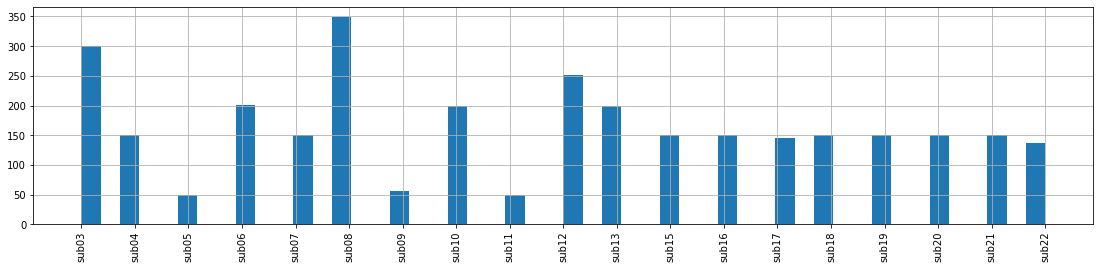

In [52]:
df = pd.read_excel('137-all-v1.xlsx')
df['sub'].hist(figsize=(19,4), xrot=90, bins=50, align='mid')

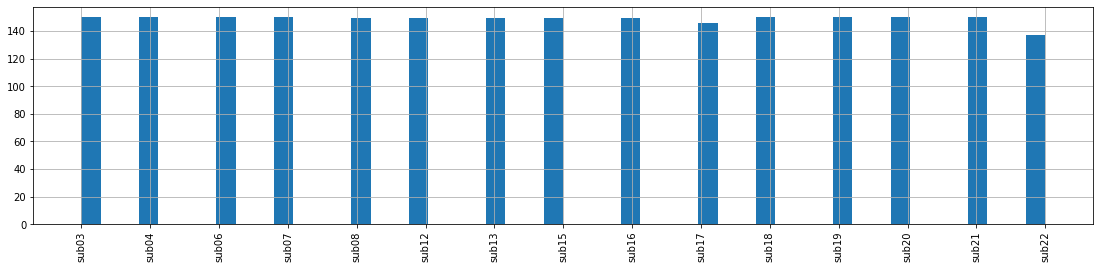

In [53]:
df = df[~df['sub'].isin(['sub05', 'sub09', 'sub11', 'sub10', ''])]
df['sub_exp'] = df['sub'] + "_" + df['exp']
df['sub_exp_run'] = df['sub_exp'] + "_" + df['run']
df = df[~df['sub_exp'].isin(['sub03_exp01', 'sub06_exp02', 'sub08_exp01', 'sub08_exp02', 'sub12_exp01', 'sub12_exp02', 'sub13_exp01'])]
df = df[df['mep_latency'] < 0.2]
df = df[df['mep_latency'] > 0]
df.to_excel('138-all-v1.xlsx')
df['sub'].hist(figsize=(19,4), xrot=90, bins=50, align='mid')

# V2

In [54]:
df['theta_power_log'] = np.log(df['theta_power'])
df['mu_power_log'] = np.log(df['mu_power'])
df['beta_power_log'] = np.log(df['beta_power'])
df['gamma_power_log'] = np.log(df['gamma_power'])
df['mep_size_log'] = np.log(df['mep_size'])
df.shape

(2228, 38)

In [55]:
def plot_interaction(y_var, y_label):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22,5))
    sns.regplot(x='theta_power_log', y=y_var, data=df[(df['theta_phase'] >= 45) & (df['theta_phase'] <= 135)], ax=ax1, marker='.')
    sns.regplot(x='theta_power_log', y=y_var, data=df[(df['theta_phase'] >= 225) & (df['theta_phase'] <= 315)], ax=ax1, marker='.')
    ax1.set_xlabel('Theta Power')
    ax1.set_ylabel(y_label)
    
    sns.regplot(x='mu_power_log', y=y_var, data=df[(df['mu_phase'] >= 45) & (df['mu_phase'] <= 135)], ax=ax2, marker='.')
    sns.regplot(x='mu_power_log', y=y_var, data=df[(df['mu_phase'] >= 225) & (df['mu_phase'] <= 315)], ax=ax2, marker='.')
    ax2.set_xlabel('Mu Power')
    ax2.set_ylabel(y_label)
    
    sns.regplot(x='beta_power_log', y=y_var, data=df[(df['beta_phase'] >= 45) & (df['beta_phase'] <= 135)], ax=ax3, marker='.')
    sns.regplot(x='beta_power_log', y=y_var, data=df[(df['beta_phase'] >= 225) & (df['beta_phase'] <= 315)], ax=ax3, marker='.')
    ax3.set_xlabel('Beta Power')
    ax3.set_ylabel(y_label)
    
    sns.regplot(x='gamma_power_log', y=y_var, data=df[(df['gamma_phase'] >= 45) & (df['gamma_phase'] <= 135)], ax=ax4, marker='.')
    sns.regplot(x='gamma_power_log', y=y_var, data=df[(df['gamma_phase'] >= 225) & (df['gamma_phase'] <= 315)], ax=ax4, marker='.')
    ax4.set_xlabel('Gamma Power')
    ax4.set_ylabel(y_label)
    
def plot_all_bands(y_var, y_label):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22,5))
    for sub in df['sub'].unique():
        x = df[df['sub'] == sub]
        sns.regplot(x='theta_power_log', y=y_var, data=x, ax=ax1, marker='.')
    ax1.set_xlabel('Theta Power')
    ax1.set_ylabel(y_label)
    
    for sub in df['sub'].unique():
        x = df[df['sub'] == sub]
        sns.regplot(x='mu_power_log', y=y_var, data=x, ax=ax2, marker='.')
    ax2.set_xlabel('Mu Power')
    ax2.set_ylabel(y_label)
    
    for sub in df['sub'].unique():
        x = df[df['sub'] == sub]
        sns.regplot(x='beta_power_log', y=y_var, data=x, ax=ax3, marker='.')
    ax3.set_xlabel('Beta Power')
    ax3.set_ylabel(y_label)
    
    for sub in df['sub'].unique():
        x = df[df['sub'] == sub]
        sns.regplot(x='gamma_power_log', y=y_var, data=x, ax=ax4, marker='.')
    ax4.set_xlabel('Gamma Power')
    ax4.set_ylabel(y_label)
    
def plot_reg(y_var, y_label):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22,5))
    sns.regplot(x='theta_power_log', y=y_var, data=df, ax=ax1, marker='.')
    ax1.set_xlabel('Theta Power')
    ax1.set_ylabel(y_label)
    
    sns.regplot(x='mu_power_log', y=y_var, data=df, ax=ax2, marker='.')
    ax2.set_xlabel('Mu Power')
    ax2.set_ylabel(y_label)
    
    sns.regplot(x='beta_power_log', y=y_var, data=df, ax=ax3, marker='.')
    ax3.set_xlabel('Beta Power')
    ax3.set_ylabel(y_label)
    
    sns.regplot(x='gamma_power_log', y=y_var, data=df, ax=ax4, marker='.')
    ax4.set_xlabel('Gamma Power')
    ax4.set_ylabel(y_label)

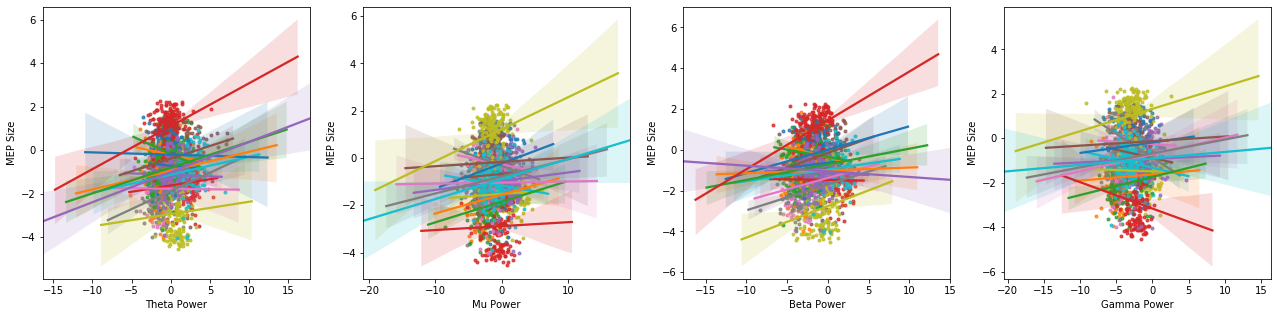

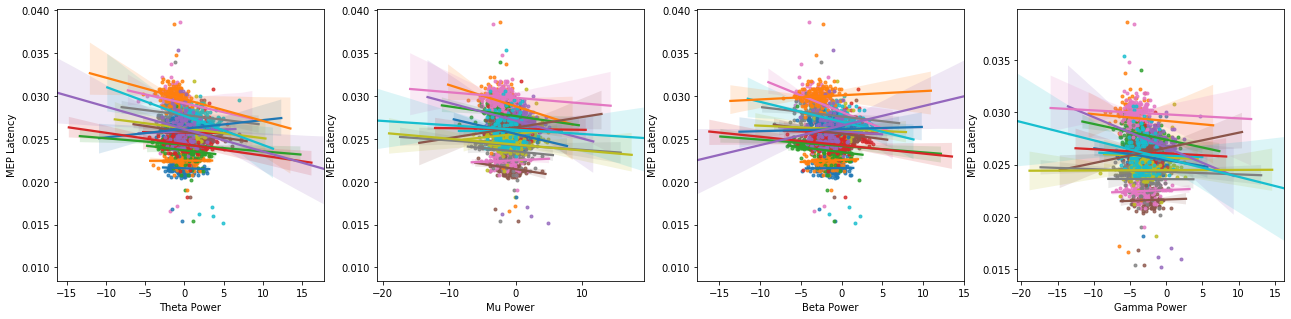

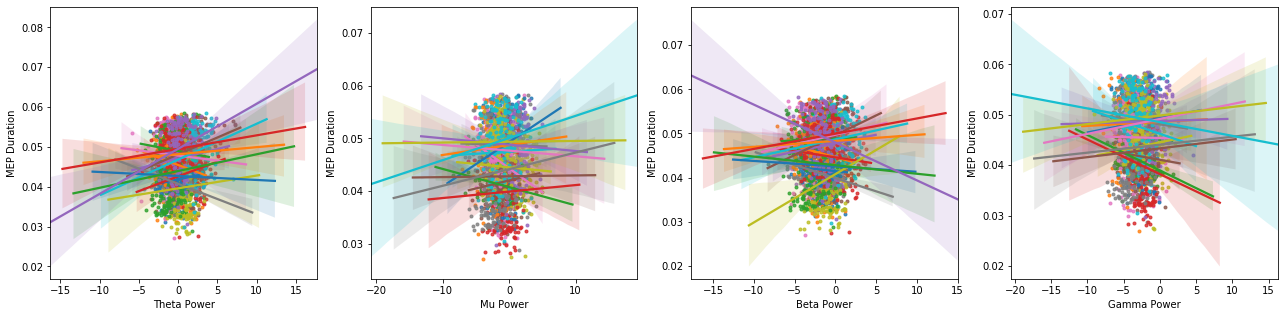

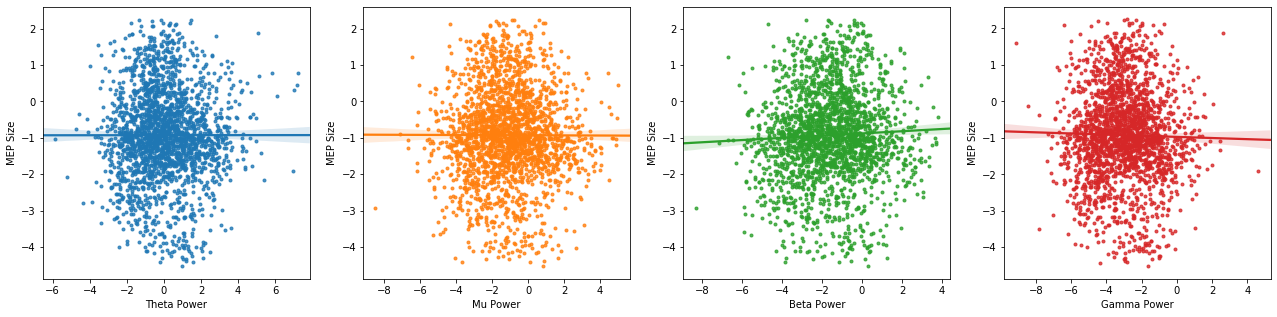

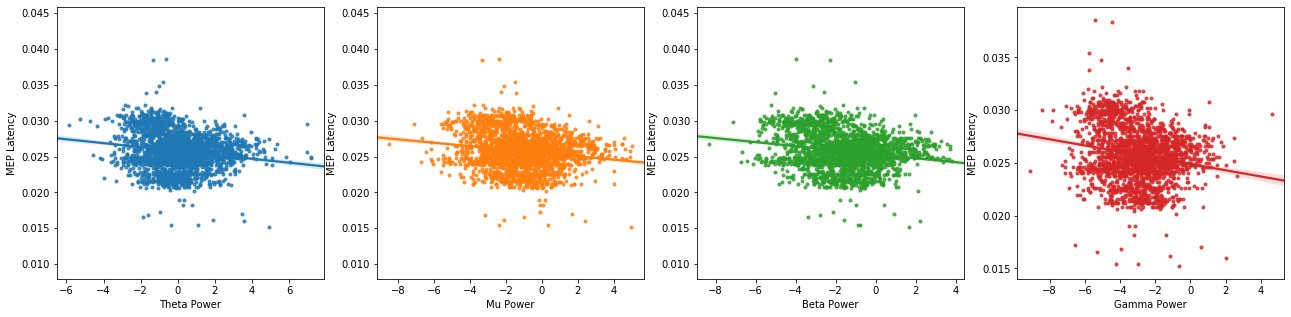

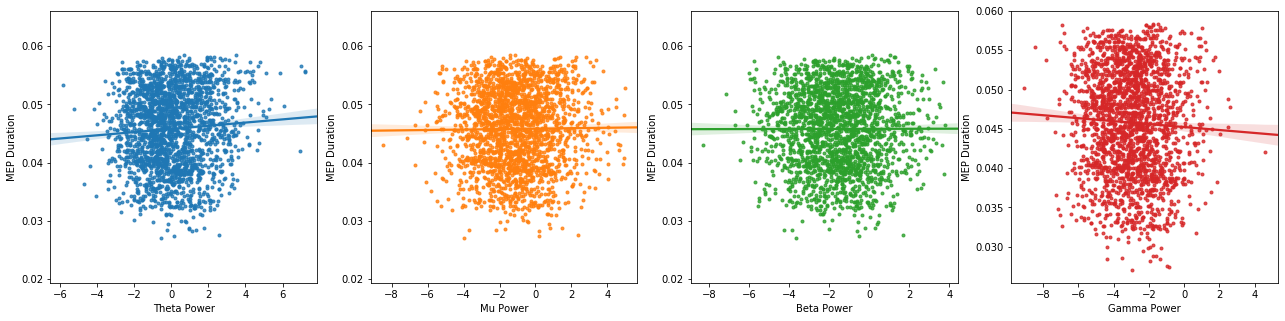

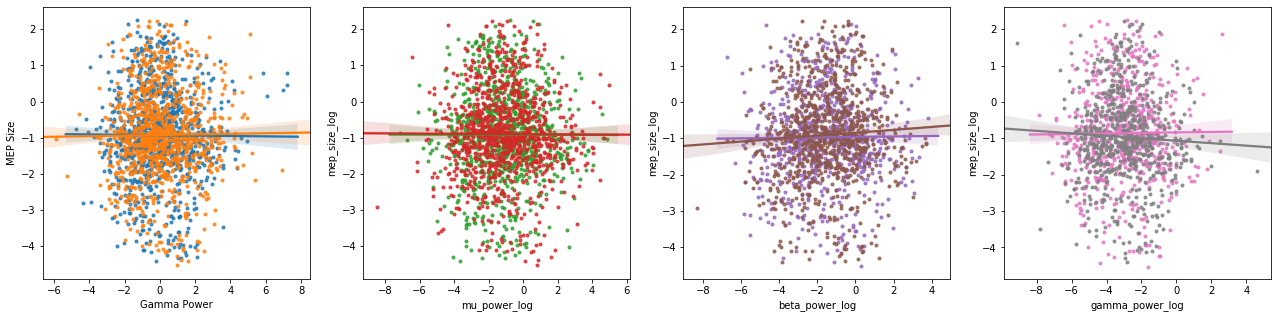

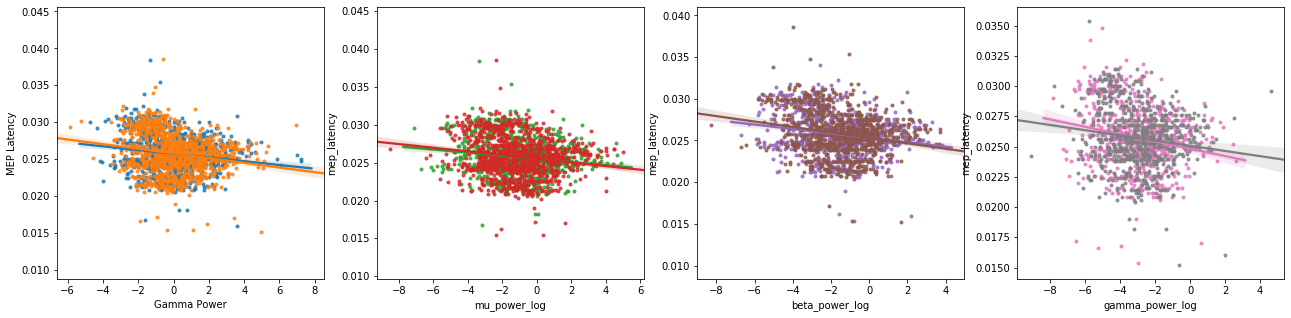

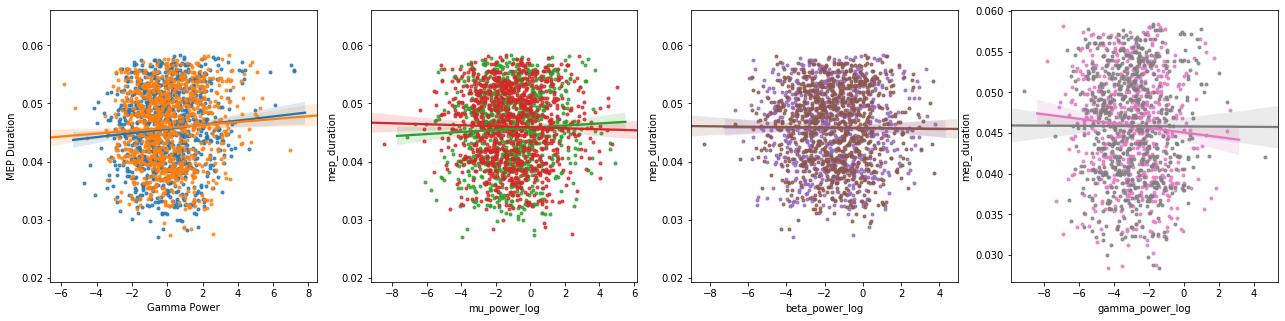

In [56]:
plot_all_bands('mep_size_log', 'MEP Size')
plot_all_bands('mep_latency', 'MEP Latency')
plot_all_bands('mep_duration', 'MEP Duration')

plot_reg('mep_size_log', 'MEP Size')
plot_reg('mep_latency', 'MEP Latency')
plot_reg('mep_duration', 'MEP Duration')

plot_interaction('mep_size_log', 'MEP Size')
plot_interaction('mep_latency', 'MEP Latency')
plot_interaction('mep_duration', 'MEP Duration')

Text(0, 0.5, 'MEP Latency')

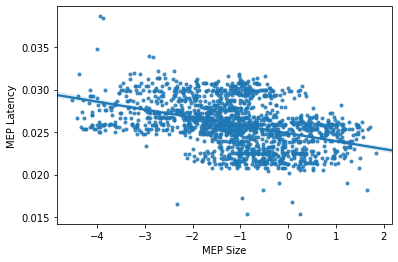

In [48]:
# plt.plot(np.log(df['mep_size']), df['mep_latency'], '.')
sns.regplot(x='mep_size_log', y='mep_latency', data=df, marker='.')
plt.xlabel('MEP Size')
plt.ylabel('MEP Latency')

Text(0, 0.5, 'MEP Duration')

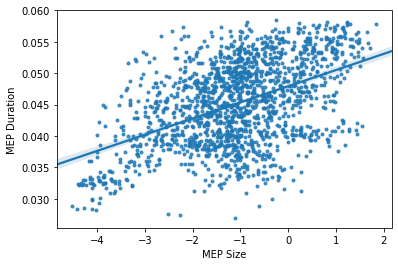

In [49]:
sns.regplot(x='mep_size_log', y='mep_duration', data=df, marker='.')
plt.xlabel('MEP Size')
plt.ylabel('MEP Duration')